# Decision Tree Classifier

In [531]:
import numpy as np
import pandas as pd
from pprint import pprint
import random
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import queue

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Helper Functions

### Data split into train and test
    Split data into 80% train data and 20% validation data. Split is random to avoid skewed data.
    Returns dataframe for training and validation data.

In [536]:
def Data_Split(df, test_to_all_ratio):
    #test size in ratio
    test_size = round(test_to_all_ratio * len(df))
    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    return train_df, test_df

#### Determine which features are numeric
    Determine which attributes in dataset are numeric to handle them separately. Numeric attributes are based on 2 conditions:
    1) data type is numerical
    2) has more than 5 discrete unique values

In [537]:
def numeric_features(df):
    numeric_list = []
    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number) and len(np.unique(df[column])) > 5:
            numeric_list.append(column)
    return numeric_list


## Data conversion (numeric to categorical)
       If numeric attributes are present in dataframe, they are converted to categorical attributes Procedure is as follows:
    1) Get discrete values of numeric attribute and count output label counts for each unique value
    2) Take max value of output value as value in dictionary with key as that unique value
    3) Find flip point in sorted attribute values, point where value of output label in dictionary changes. Record change point and take average of them as split points
    4) change attribute values by splitting them into split points recorded
    

In [568]:
def convert_numeric_to_categorical(df, test_df, numeric_features_list):
    feature_list_splits = {}
    for feature in numeric_features_list:
        df.sort_values(feature, inplace=True)
        unique_values = np.unique(df[feature])
        data_list = df[feature].tolist()
        output_list = []
        final_data_list = []
        feature_discrete_attributes = []
        feature_discrete_attribute_values = []
        for value in unique_values:
            temp_data = df.loc[df[feature] == value]
            value_outputs, value_output_counts =  np.unique(temp_data['output'], return_counts=True)
            value_max = value_outputs[np.argmax(value_output_counts)]
            feature_discrete_attributes.append(value)
            feature_discrete_attribute_values.append(value_max)

        change_value = feature_discrete_attribute_values[0]
        for i in range (len(feature_discrete_attributes)):
            if i == 0:
                continue
            if feature_discrete_attribute_values[i] != change_value:
                output_list.append(round((feature_discrete_attributes[i] + feature_discrete_attributes[i - 1]) / 2, 3))
                change_value = feature_discrete_attribute_values[i]
        
        output_list.append(math.inf)
        output_list.insert(0, -1)
        list_itr = 0
        label_itr = 0
        feature_list_splits[feature] = output_list

        df[feature] = pd.cut(df[feature], output_list)
            
    return df, feature_list_splits

Convert test dataframe numeric values into categorical according to splits found earlier

In [539]:
def test_data_preprocessing(test_df, numeric_features_list, feature_list_splits):
    for feature in numeric_features_list:
        test_df[feature] = pd.cut(test_df[feature], feature_list_splits[feature])
    return test_df

## Calculation of entropy, gini_index, misclassification rate
    

In [541]:
def Base_Entropy(df):
    data = df.values
    label_values = data[:,-1]
    _, counts_unique_classes = np.unique(label_values, return_counts=True)
    l ,r = counts_unique_classes[0], counts_unique_classes[1]
    total = l + r
    entropy = -(l/total*np.log2(l/total) + r/total*np.log2(r/total))
    return entropy

In [543]:
def Calculate_Entropy(df, column):
    data = df.values
    rows = np.size(data, 0)
    feature_values, feature_count = np.unique(data[:,column],return_counts = True)
    entropy = 0
    for feature in feature_values:
        temp = data[data[:,column] == feature]
        _, temp_counts = np.unique(temp[:, -1], return_counts=True)
        if len(temp_counts) == 1:
            return 0
        l, r = temp_counts[0]/temp_counts.sum(), temp_counts[1]/temp_counts.sum()
        feature_entropy = -(l * np.log2(l) + r * np.log2(r))
        entropy = entropy + (temp_counts.sum()/rows * feature_entropy)
    return entropy
            

In [544]:
def Base_Gini_Index(df):
    feature_value, feature_count = np.unique(df['output'], return_counts=True)
    q = feature_count[0] / feature_count.sum()
    gini = 2 * q * (1 -q)
    return gini

In [546]:
def Calculate_Gini_Index(df, column):
    data = df.values
    rows = np.size(data, 0)
    feature_values, feature_count = np.unique(data[:,column],return_counts = True)
    gini = 0
    for feature in feature_values:
        temp = data[data[:,column] == feature]
        _, temp_counts = np.unique(temp[:, -1], return_counts=True)
        if len(temp_counts) == 1:
            return 0
        q = temp_counts[0] / temp_counts.sum()
        attribute_gini = 2 * q * (1 - q)
        gini = gini + (temp_counts.sum()/rows * attribute_gini)
    return gini

In [547]:
def Base_Misclassification_Rate(df):
    feature_value, feature_count = np.unique(df['output'], return_counts=True)
    q = feature_count[0] / feature_count.sum()
    misclassification = min(q, 1- q)
    return misclassification

In [548]:
def Calculate_Misclassification_Rate(df, column):
    data = df.values
    rows = np.size(data, 0)
    feature_values, feature_count = np.unique(data[:,column],return_counts = True)
    misclassification = 0
    for feature in feature_values:
        temp = data[data[:,column] == feature]
        _, temp_counts = np.unique(temp[:, -1], return_counts=True)
        if len(temp_counts) == 1:
            return 0
        q = temp_counts[0] / temp_counts.sum()
        attribute_misclassification = min(q, 1- q)
        misclassification = misclassification + (temp_counts.sum()/rows * attribute_misclassification)
    return misclassification

## Calculating maximum information gain out of all attributes
   To select best attribute for data split while making decision tree. This value is based on entropy function or gini index or misclassification rate to calculate maximum information gain attribute

In [550]:
def Max_Info_Gain(df, attribute_index_list, impurity_function = 'entropy'):
    data = df
    if impurity_function == 'entropy':
        Base = Base_Entropy(df)
    elif impurity_function == 'gini':
        Base = Base_Gini_Index(df)
    elif impurity_function == 'misclassification':
        Base = Base_Misclassification_Rate(df)        
    gain = -999
    max_info_col = -1
    for i in attribute_index_list:
        if impurity_function == 'entropy':
            temp_impurity = Calculate_Entropy(df, i)
        elif impurity_function == 'gini':
            temp_impurity = Calculate_Gini_Index(df, i)
        elif impurity_function == 'misclassification':
            temp_impurity = Calculate_Misclassification_Rate(df, i)
        temp_gain = Base - temp_impurity
        if temp_gain > gain:
            gain = temp_gain
            max_info_col = i
    return max_info_col, gain

## Decision Tree Algorithm
   Decision tree algorithm is based on ID3 algorithm for tree construction.

In [551]:
def Decision_Tree(data, old_data, index_list, impurity_function = 'entropy', counter = 0, max_depth=50):
    column_headers = train_df.columns
    if len(np.unique(data['output'])) <= 1:
        return {'leaf' : np.unique(data['output'])[0]}, 1
    
    elif len(data) == 0:
        return {'leaf':np.unique(old_data['output'])[np.argmax(np.unique(old_data[:,-1],return_counts = True)[1])]}, 1
    
    elif len(index_list) == 0:
        return {'leaf':np.unique(data['output'])[np.argmax(np.unique(data['output'],return_counts = True)[1])]}, 1
    
    elif counter == max_depth:
        return {'leaf':np.unique(data['output'])[np.argmax(np.unique(data['output'],return_counts=True)[1])]}, 1
    counter += 1
    best_info_gain_index,_ = Max_Info_Gain(data, index_list[:], impurity_function)
    index_list.remove(best_info_gain_index)
    
    root = {}
    root[column_headers[best_info_gain_index]] = {}
    
    node_sum = 0
    for attribute in data[column_headers[best_info_gain_index]].unique():
        attribute_data = data[data[column_headers[best_info_gain_index]] == attribute]
        root[column_headers[best_info_gain_index]][attribute], c = Decision_Tree(attribute_data, data, index_list[:], impurity_function, counter, max_depth)
        node_sum += c
    return root, node_sum
        

## Predict individual query of test

In [553]:
def predict_query(query, node):
    try:
        if list(node.keys())[0] == 'leaf':
            return node['leaf']
        else:
            value = query[list(node.keys())[0]]
            return predict_query(query,node[list(node.keys())[0]][value])
    except:
        return 0

## Test data prediction
   decision tree node and test data frame is passed.
   return accuracy, precision, recall, f1

In [555]:
def predict_test(test_df,node):
    predictions = []
    for i,rows in test_df.iterrows():
        predictions.append(predict_query(rows,node))
    target_value = test_df['output'].tolist()
    tp,fp,tn,fn = 0,0,0,0
    for i in range(len(target_value)):
        if target_value[i] == predictions[i] and target_value[i] == 1:
            tp = tp + 1
        elif target_value[i] == predictions[i] and target_value[i] == 0:
            tn = tn + 1
        elif target_value[i] != predictions[i] and target_value[i] == 0:
            fp = fp + 1
        else:
            fn = fn + 1

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    if tp + fp != 0:
        precision = tp/(tp+fp)
    else:
        precision = 0
    if tp + fn != 0:
        recall = tp/(tp+fn)
    else:
        recall = 0
    if precision == 0 or recall == 0:
        f1 = 0
    else:
        f1 = 2 / ((1 / recall) + (1 / precision))
    return accuracy, precision, recall, f1

## Part 1 (Only Categorical Data)
 Based on above helper functions we can now test data for training and prediction



In [572]:
df = pd.read_csv('/home/vivek/train.csv')

In [573]:
df['output'] = df['left']
df = df.drop(['left'], axis=1)
cols = [0, 1, 2, 3, 4]
df = df.drop(df.columns[cols], axis=1)
column_headers = df.columns
feature_indexes = list(range(len(df.columns) - 1))

In [574]:
random.seed(0)
train_df, test_df = Data_Split(df, 0.2)
original_train_df, original_test_df = train_df.copy(), test_df.copy()
train_df, feature_list_splits = convert_numeric_to_categorical(train_df, test_df, numeric_features(df)) 
test_df = test_data_preprocessing(test_df, numeric_features(test_df), feature_list_splits)

In [575]:
categorical_node, _ = Decision_Tree(train_df, train_df, feature_indexes[:])
#pprint(categorical_node)
accuracy, precision, recall, f1 = predict_test(test_df,categorical_node)
print("accuracy is :", accuracy * 100, "%")
print("Precision is :", precision * 100, "%")
print("recall is :", recall * 100, "%")
print("F1 score is:", f1)

accuracy is : 74.86654804270462 %
Precision is : 100.0 %
recall is : 0.17667844522968199 %
F1 score is: 0.003527336860670194


## Observations and results
###### After observing result over multiple training- validation splits, Value of accuracy comes out in range of 74-77 %
###### Precision value is always close to 100% which indicates algorithm is successfull in predicting postive if present
###### Recall is close to 0% and same case for f1 score

## Part 2 (numerical + Categorical data)
 when considering both categorical and numerical data, normal decision tree algorithm will cosider each unique value of numerical data as different class which makes decision tree biased and any new numeric data value will not be accurately predicted. Hence we are doing data preprocessing on numeric attributes to convert them to categorical

In [576]:
df = pd.read_csv('/home/vivek/train.csv')


In [577]:
df['output'] = df['left']
df = df.drop(['left'], axis=1)
column_headers = df.columns
feature_indexes = list(range(len(df.columns) - 1))


In [578]:
random.seed(0)
train_df, test_df = Data_Split(df, 0.2)
original_train_df, original_test_df = train_df.copy(), test_df.copy()
train_df, feature_list_splits = convert_numeric_to_categorical(train_df, test_df, numeric_features(df)) 
test_df = test_data_preprocessing(test_df, numeric_features(test_df), feature_list_splits)

In [579]:
full_node, _ = Decision_Tree(train_df, train_df, feature_indexes[:])
#pprint(full_node)
accuracy, precision, recall, f1 = predict_test(test_df,full_node)
print("accuracy is :", accuracy * 100, "%")
print("Precision is :", precision * 100, "%")
print("recall is :", recall * 100, "%")
print("F1 score is:", f1)

accuracy is : 95.32918149466192 %
Precision is : 91.38240574506284 %
recall is : 89.92932862190813 %
F1 score is: 0.9065004452359751


### Observation and result
###### After observing result over multiple training- validation splits, Value of accuracy comes out in range of 94-96 %
###### Precision value is 89-91% which indicates algorithm is successfull in predicting postive if present
###### Recall is close to 90% and same case for f1 score
### This results indicate that considering all attributes provide better accuracy and better f1 score which means better result overall

## Part 3 Taking different Impurity measures
##### Until now we have considered only entropy value as basis to calculate best possible attribute for maximum information gain. Lets check results for gini index and misclassification rate

In [580]:
gini_index_node, _ = Decision_Tree(train_df, train_df, feature_indexes[:], impurity_function='gini')
accuracy, precision, recall, f1 = predict_test(test_df,gini_index_node)
print("Doing decision tree with Gini Index")
print("accuracy is :", accuracy * 100, "%")
print("Precision is :", precision * 100, "%")
print("recall is :", recall * 100, "%")
print("F1 score is:", f1)
misclassification_node, _ = Decision_Tree(train_df, train_df, feature_indexes[:], impurity_function='misclassification')
accuracy, precision, recall, f1 = predict_test(test_df,misclassification_node)
print("Doing decision tree with Misclassification rate")
print("accuracy is :", accuracy * 100, "%")
print("Precision is :", precision * 100, "%")
print("recall is :", recall * 100, "%")
print("F1 score is:", f1)

Doing decision tree with Gini Index
accuracy is : 95.32918149466192 %
Precision is : 91.38240574506284 %
recall is : 89.92932862190813 %
F1 score is: 0.9065004452359751
Doing decision tree with Misclassification rate
accuracy is : 95.32918149466192 %
Precision is : 91.38240574506284 %
recall is : 89.92932862190813 %
F1 score is: 0.9065004452359751


### Obervation and results
 Based on results obtained, it seems that for this partcular dataset any impurity measure makes same decision tree and hence provides similar results for performance measures. It is possible for other dataset to have some impurity function better than some other.

## Part 4. Data vizualization
    from data provided, satisfaction level and average monthly hours attribute are selected for plotting graph


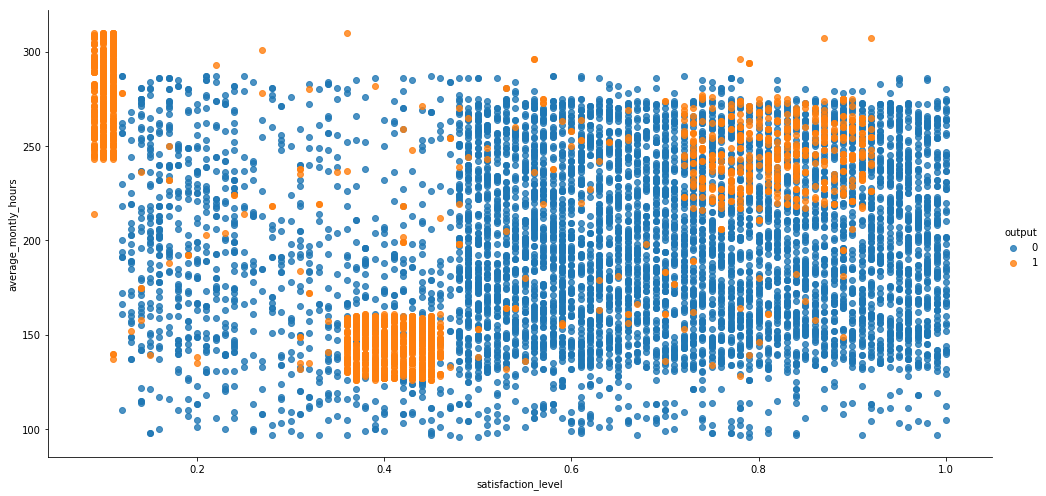

In [581]:
sns.lmplot(x='satisfaction_level', y='average_montly_hours', data=original_train_df, hue='output', height=7, aspect=2, fit_reg=False)

### Observation:
 #### based on above graph, decision boundary, though not very accurate but divides output label.
 #### e.g if satisfacton_level is between 0.37-0.44 and average monthly hours between 125-170 we can predict output label will be 1 and so on
 

## 5. Training and Validation Error
#### To calculate errors for different depths decision tree is trained for different values of depth and correspponding number of nodes. Results obtained is recorded for training and validation error.

In [582]:
train_error = []
test_error = []
depth = []
no_of_nodes = []
feature_indexes = list(range(len(df.columns) - 1))
for i in range(1,10):
    depth.append(i)
    node, total_node = Decision_Tree(train_df, train_df, feature_indexes[:], 'entropy', max_depth=i)
    accuracy, precision, recall, f1 = predict_test(test_df,node)
    del node
    test_error.append(1 - accuracy)
    no_of_nodes.append(total_node)

for i in range(1,10):
    node, _ = Decision_Tree(train_df, train_df, feature_indexes[:], 'entropy', max_depth=i)
    accuracy, precision, recall, f1 = predict_test(train_df,node)
    del node
    train_error.append(1 - accuracy)

print("Training error")
print(train_error)
print("test error")
print(test_error)


Training error
[0.1043381535038932, 0.09555061179087876, 0.08754171301446056, 0.05684093437152393, 0.04671857619577313, 0.03848720800889882, 0.0362625139043381, 0.03281423804226924, 0.03025583982202451]
test error
[0.11298932384341642, 0.10409252669039148, 0.09741992882562278, 0.06717081850533813, 0.05604982206405695, 0.0462633451957295, 0.04492882562277578, 0.045373665480427094, 0.04670818505338081]


#### Based on this result, it is apparent that error value reduces when you increase number of nodes, depth
#### plotting graph

Text(0, 0.5, 'Test error')

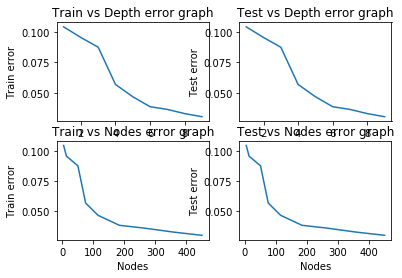

In [583]:
plt.subplot(2, 2, 1)
plt.plot(depth, train_error)
plt.title('Train vs Depth error graph')
plt.xlabel('depth')
plt.ylabel('Train error')

plt.subplot(2, 2, 2)
plt.plot(depth, train_error)
plt.title('Test vs Depth error graph')
plt.xlabel('depth')
plt.ylabel('Test error')

plt.subplot(2, 2, 3)
plt.plot(no_of_nodes, train_error)
plt.title('Train vs Nodes error graph')
plt.xlabel('Nodes')
plt.ylabel('Train error')

plt.subplot(2, 2, 4)
plt.plot(no_of_nodes, train_error)
plt.title('Test vs Nodes error graph')
plt.xlabel('Nodes')
plt.ylabel('Test error')

## Part 6. Handling missing attribute values

### If data value for attribute is missing, possible approaches are:
 #### 1. traverse back to parent node of missing atribute in tree and take maximum value of output label as prediction
 #### 2. Problem with above approach is if missing attribute happens to be very high up in decision tree traversal, we are ingoring other possible atttribute values which would have helped to make better prediction. To remedy this, we can traverse all possible values for missing value in its decision tree node and traverse with other attribute values which are provided. Once at leaf, average out results of all possible leaf to get prediction.

## Data prediciton for test csv file:

In [585]:
def predict_external_test(filepath):
    external_test_df = pd.read_csv(filepath)
    #print(external_test_df)
    external_test_df['output'] = external_test_df['left']
    external_test_df = external_test_df.drop(['left'], axis=1)
    external_test_df = test_data_preprocessing(external_test_df, numeric_features(external_test_df), feature_list_splits)
    accuracy, precision, recall, f1 = predict_test(external_test_df,full_node)
    return accuracy, f1



In [586]:
accuracy, f1 = predict_external_test('/home/vivek/another_test.csv')